In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import Binarizer, PowerTransformer
from sklearn.metrics import mean_squared_log_error
from cycler import cycler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import warnings

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict
from scipy.stats import t
warnings.filterwarnings('ignore')

def mean_confidence_interval(x, conf=95):
    """
    Compute a confidence interval for the mean of the values in x.

    Params:
        x:    -> Array with the values to compute the mean confidence interval.
        conf: -> Level of confidence (0 < conf < 100)

    Returns:
        conf: -> Confidence interval [lim_inf, lim_sup]
    """
    
    mean = np.mean(x)
    tsign = np.abs(t.ppf((1-conf/100)/2, len(x)-1))
    std = np.std(x, ddof=1)
    std_error = std / np.sqrt(len(x))
    conf = [mean - tsign*std_error, mean + tsign*std_error]
    return conf

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

numeric_cols = train.columns[~(train.dtypes == object)].tolist()[1:]
object_cols = train.columns[(train.dtypes==object)].tolist()

target = numeric_cols.pop(-1)
ytrain = train[target]

In [3]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.facecolor'] = '#FBFFFE'
plt.rcParams['figure.facecolor'] = '#FBFFFE'
plt.rcParams['text.color'] = '#162A50'
plt.rcParams['lines.color'] = '#FBFFFE'
plt.rcParams['grid.color'] = '#0E1C36'
plt.rcParams['grid.alpha'] = 0.1
plt.rcParams['axes.labelcolor'] ='#162A50'
plt.rcParams['axes.prop_cycle'] = cycler(color=['#4472CA', '#D62828', '#FFC857', '#0E1C36', '#B388EB'])

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span> Initial Dataset inspection
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Dataset inspection
</div>

Train size: (1460, 81)
Test size: (1459, 80)


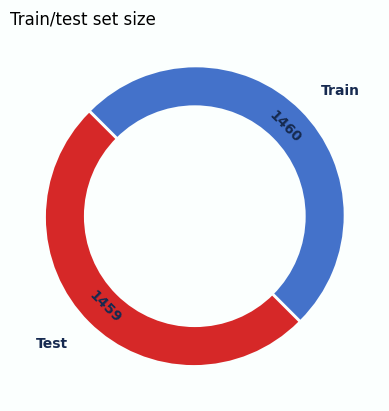

In [4]:
fig, ax = plt.subplots()

pie_elements = ax.pie(
    x=[len(train), len(test)], 
    explode=[.01, .01], 
    startangle=-45, 
    autopct='%.2f',
    labels=['Train', 'Test'],
    pctdistance=0.85, 
    labeldistance=1.2
)
circle = plt.Circle((0.5, 0.5), 0.3, facecolor='#FBFFFE', transform=ax.transAxes)
ax.add_patch(circle)

ax.set_title('Train/test set size', loc='left', color='black')
plt.setp(pie_elements[1], fontweight='bold')
for pct_label, size in zip(pie_elements[2], [len(train), len(test)]):
    pct_label.set(rotation=-45, weight='bold')
    pct_label.set_text(size)

print('Train size:', train.shape)
print('Test size:', test.shape)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
The dataset consists of 2919 instances (houses) and 80 features each. It was split into a training and test set using a 50/50 split. The training set also includes the target (price) for the regression task.
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Feature data types
</div>

Text(0.0, 1.0, 'Count of feature data types')

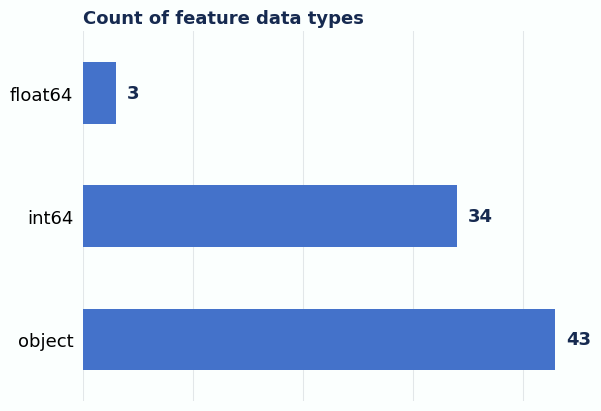

In [5]:
fig, ax = plt.subplots()

bars = train.drop(columns='SalePrice').dtypes.value_counts().plot.barh(zorder=5)
ax.grid(axis='x')
ax.tick_params(left=False, bottom=False, labelsize=13, labelbottom=False)
ax.spines[['bottom', 'left']].set_visible(False)

for bar in bars.get_children()[:3]:
    ax.annotate(bar.get_width(), 
                xy=(bar.get_width()+1, bar.get_y() + bar.get_height()/2), 
                va='center', ha='left', fontsize=13, fontweight=1000)

ax.set_title('Count of feature data types', fontsize=13, loc='left', 
             weight='bold')

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
43 of the features are categorical (type object), while the remaining 37 are numeric (3 float and 34 integer).
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Target variable
</div>

Text(0.65, 0.3, 'min: $  34,900\nmax: $755,000')

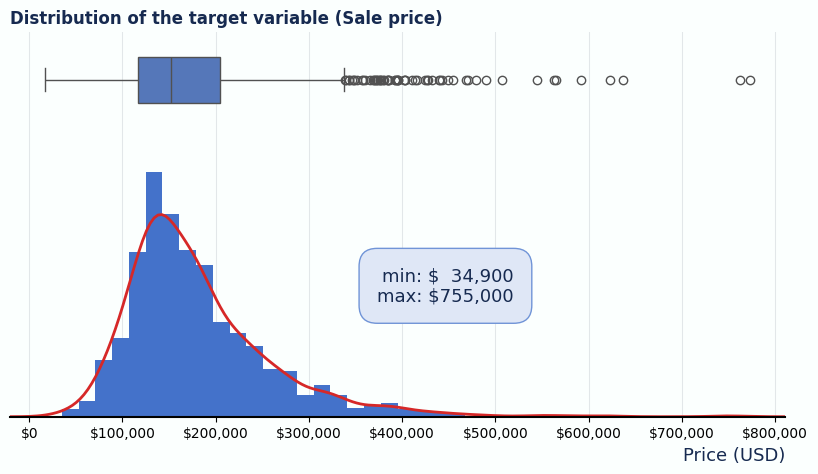

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
ax.margins(x=0)
ax.hist(ytrain, bins=40, density=True, zorder=2)
sns.kdeplot(ytrain, lw=2)
ax.xaxis.set_major_locator(plt.MultipleLocator(100000))
ax.xaxis.set_major_formatter(plt.FuncFormatter(
    lambda vi, xi: f'${vi:,.0f}'))
ax.spines['left'].set_visible(False)
ax.set_yticks([]);
ax.set_ylim(0, 1.5*ax.get_ylim()[1])
ax.grid(axis='x')
ax.set_xlabel('Price (USD)', fontsize=13, loc='right')
ax.set_ylabel('')

axb = ax.inset_axes([0, 0.8, 1, 0.15])
sns.boxplot(x=ytrain, ax=axb, color='C0')
axb.axis('off')

ax.set_title('Distribution of the target variable (Sale price)', loc='left', 
             fontweight='bold');

ax.annotate(f'min: $  {train["SalePrice"].min():,.0f}\nmax: ${train["SalePrice"].max():,.0f}', 
            xy=(0.65, 0.3), xycoords='axes fraction', fontsize=13, ha='right', 
            bbox={'boxstyle':'round', 'pad':1, 'facecolor':'#DFE7F6', 'ec':'#7094D7'}, )

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
The target value (Price of the house in USD) ranges from $\$34,900$ to $\$755,000$, with a mean around $\$180,000$, and a positively skewd distribution. Although it is not usually needed to scale the target variable, given the large values, we should scale before building a regression machine learning model. 
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Missing values
</div>

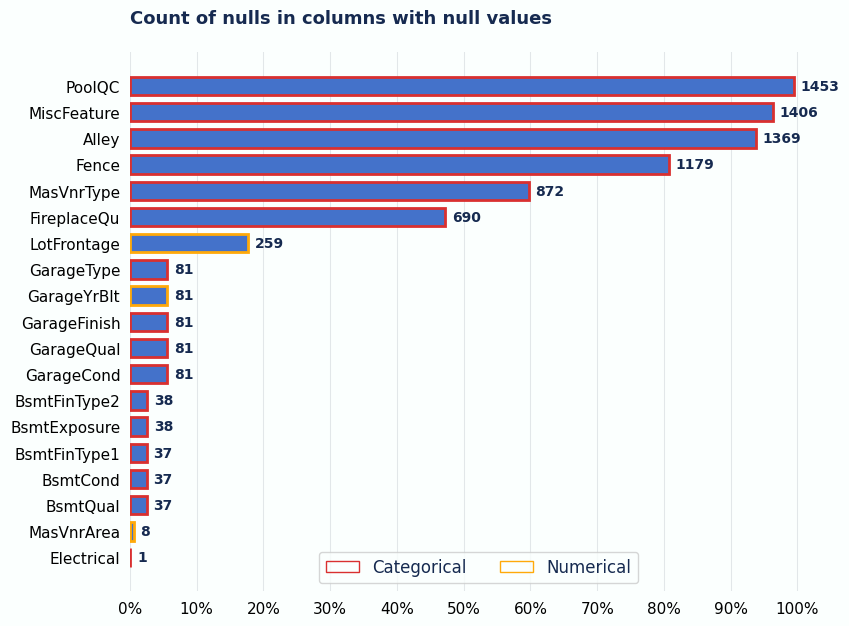

In [7]:
import matplotlib as mpl

nulls_by_col = train.isnull().sum()
train_with_nulls = train[nulls_by_col[nulls_by_col>0].index]
nulls_per_column = train_with_nulls.isnull().sum().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 7))
bars = ax.barh(nulls_per_column.index, nulls_per_column/len(train), zorder=5, 
               height=0.7)
ax.tick_params(bottom=False, left=False, labelsize=11)
ax.grid(axis='x')

ax.spines[['bottom', 'left']].set_visible(False)

ax.set_title('Count of nulls in columns with null values\n', loc='left', weight='bold', 
             fontsize=13)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_formatter(plt.FuncFormatter(
    lambda vi, xi: f'{100*vi:.0f}%'))

for bar, nulls in zip(bars, nulls_per_column):
    ax.annotate(f'{nulls}', 
                xy=(bar.get_width() + .01, bar.get_y() + bar.get_height()/2), va='center', 
                ha='left', fontweight='bold')

for bar, col in zip(bars, nulls_per_column.index):
    if train[col].dtype == object:
        bar.set_edgecolor('#D93030')
    else:
        bar.set_edgecolor('#FFA90A')
    bar.set_linewidth(2)

rec_object = plt.Rectangle([0, 0], 0.1, 0.1, label='Categorical', facecolor='none', 
                           edgecolor='#D93030')
rec_numeric = plt.Rectangle([0, 0], 0.1, 0.2, label='Numerical', facecolor='none', 
                            edgecolor='#FFA90A')
ax.legend(handles=[rec_object, rec_numeric], loc='lower center', ncol=2, 
          fontsize=12)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
There are 19 columns with missing values, most of them (16) categorical. The features PoolQC, MIscFeature, Alley, Fencem MasVnrType and FireplaceQu are the columns with most missing values (from 48 to 99%). However, this missing values could be informative. For instane, a missing value in PoolQC indicates that the house doesen't have a pool, so we'll impute a flag value, and we'll handle them as another feature.
<br><br>
All the remaining columns have less than 10% of missing values (except for LotFrontage). For the numerical columns, we'll use a KNNImputer to impute them. 
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Now, let's do an Exploratory Data Analysis to get some insights of the data. But before, let's impute the missing values in both the trainig and test set, and scale the target variable. Since we would like our model to not predict negative values, we'll use a min-max scaler. 
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Imputation of missing values
</div>

In [8]:
train = train[numeric_cols + object_cols]
for col in object_cols:
    train[col] = train[col].fillna('NA')

imputer = ColumnTransformer([
    ('imputer', KNNImputer(), numeric_cols)
], remainder='passthrough')

train = imputer.fit_transform(train)
train = pd.DataFrame(train, columns=numeric_cols + object_cols)

for col in numeric_cols:
    train[col] = pd.to_numeric(train[col])

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [9]:
print('Total missing values', train.isnull().sum().sum())

Total missing values 0


<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
The training set is clean, so let's do the same with the test set (using the imputer trained with the training data).
</div>

In [10]:
for col in object_cols:
    test[col] = test[col].fillna('NA')

test = imputer.transform(test)
test = pd.DataFrame(test, columns=numeric_cols + object_cols)

for col in numeric_cols:
    test[col] = pd.to_numeric(test[col])

test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,Attchd,Unf,TA,TA,Y,NA,MnPrv,NA,WD,Normal
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,Attchd,Unf,TA,TA,Y,NA,NA,Gar2,WD,Normal
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,Attchd,Fin,TA,TA,Y,NA,MnPrv,NA,WD,Normal
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,Attchd,Fin,TA,TA,Y,NA,NA,NA,WD,Normal
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [11]:
print(f'Total missing values: ', test.isnull().sum().sum())

Total missing values:  0


<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Now, neither the training set nor the testing set has missing values.
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
And then, let's scale the target (Sale Price) variable) to 0-1 using the MinMax scaler
</div>

In [12]:
yscaler = MinMaxScaler()
ytrain_scaled = yscaler.fit_transform(ytrain.values[:, None])[:, 0]

Text(0.65, 0.3, 'min:  0\nmax: 1')

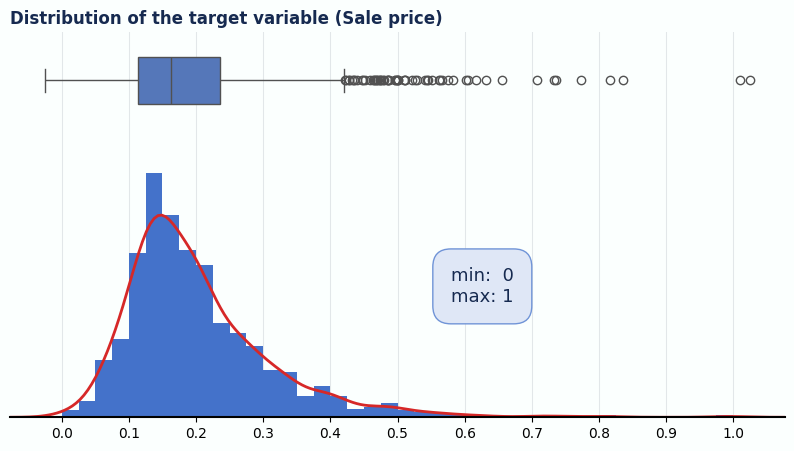

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.margins(x=0)
ax.hist(ytrain_scaled, bins=40, density=True, zorder=2)
sns.kdeplot(ytrain_scaled, lw=2)
ax.xaxis.set_major_locator(plt.MultipleLocator(.1))

ax.spines['left'].set_visible(False)
ax.set_yticks([]);
ax.set_ylim(0, 1.5*ax.get_ylim()[1])
ax.grid(axis='x')
#ax.set_xlabel('Price (USD)', fontsize=13, loc='right')
ax.set_ylabel('')

axb = ax.inset_axes([0, 0.8, 1, 0.15])
sns.boxplot(x=ytrain, ax=axb, color='C0')
axb.axis('off')

ax.set_title('Distribution of the target variable (Sale price)', loc='left', 
             fontweight='bold');

ax.annotate(f'min:  {ytrain_scaled.min():,.0f}\nmax: {ytrain_scaled.max():,.0f}', 
            xy=(0.65, 0.3), xycoords='axes fraction', fontsize=13, ha='right', 
            bbox={'boxstyle':'round', 'pad':1, 'facecolor':'#DFE7F6', 'ec':'#7094D7'}, )

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
The target is now scaled to the range 0-1 and its distribution has the same shape as the original. We must save our transformer to inverse-transform our predictions.
</div>

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span>Exploratory Data Analysis
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Numeric features
</div>

In [14]:
numeric_description = pd.DataFrame({
    'count_notnull': train[numeric_cols].count(),
    'count_null': train[numeric_cols].isnull().sum(axis=0),
    '% null': (100*train[numeric_cols].isnull().sum(axis=0) / len(train)).round(1),
    'min': train[numeric_cols].min(),
    'max': train[numeric_cols].max(),
    'mean': train[numeric_cols].mean().round(1),
    'median': train[numeric_cols].median(),
    'std': train[numeric_cols].std().round(1),
    'skew': [skew(train[col][train[col].notnull()]).round(2) for col in numeric_cols],
    'unique': [len(train[col].unique()) for col in numeric_cols]
}).sort_values(by='skew', ascending=False)

print(f'Count numeric features: {len(numeric_cols)}')
numeric_description

Count numeric features: 36


,count_notnull,count_null,% null,min,max,mean,median,std,skew,unique
MiscVal,1460,0,0.0,0.0,15500.0,43.5,0.0,496.1,24.45,21
PoolArea,1460,0,0.0,0.0,738.0,2.8,0.0,40.2,14.81,8
LotArea,1460,0,0.0,1300.0,215245.0,10516.8,9478.5,9981.3,12.20,1073
3SsnPorch,1460,0,0.0,0.0,508.0,3.4,0.0,29.3,10.29,20
LowQualFinSF,1460,0,0.0,0.0,572.0,5.8,0.0,48.6,9.00,24
KitchenAbvGr,1460,0,0.0,0.0,3.0,1.0,1.0,0.2,4.48,4
BsmtFinSF2,1460,0,0.0,0.0,1474.0,46.5,0.0,161.3,4.25,144
ScreenPorch,1460,0,0.0,0.0,480.0,15.1,0.0,55.8,4.12,76
BsmtHalfBath,1460,0,0.0,0.0,2.0,0.1,0.0,0.2,4.10,3
EnclosedPorch,1460,0,0.0,0.0,552.0,22.0,0.0,61.1,3.09,120


<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Overall, there are 36 numeric features. Since we imputed the missing values beforehand, there are no features with missing values. Most of the features have a very wide range, necessitating scaling. Additionally, while these are numeric features, some appear to be categorical due to the limited number of unique values. We could explore treating them as categorical features and applying an encoding strategy like OneHotEncoder or SequentialEncoder.
</div>

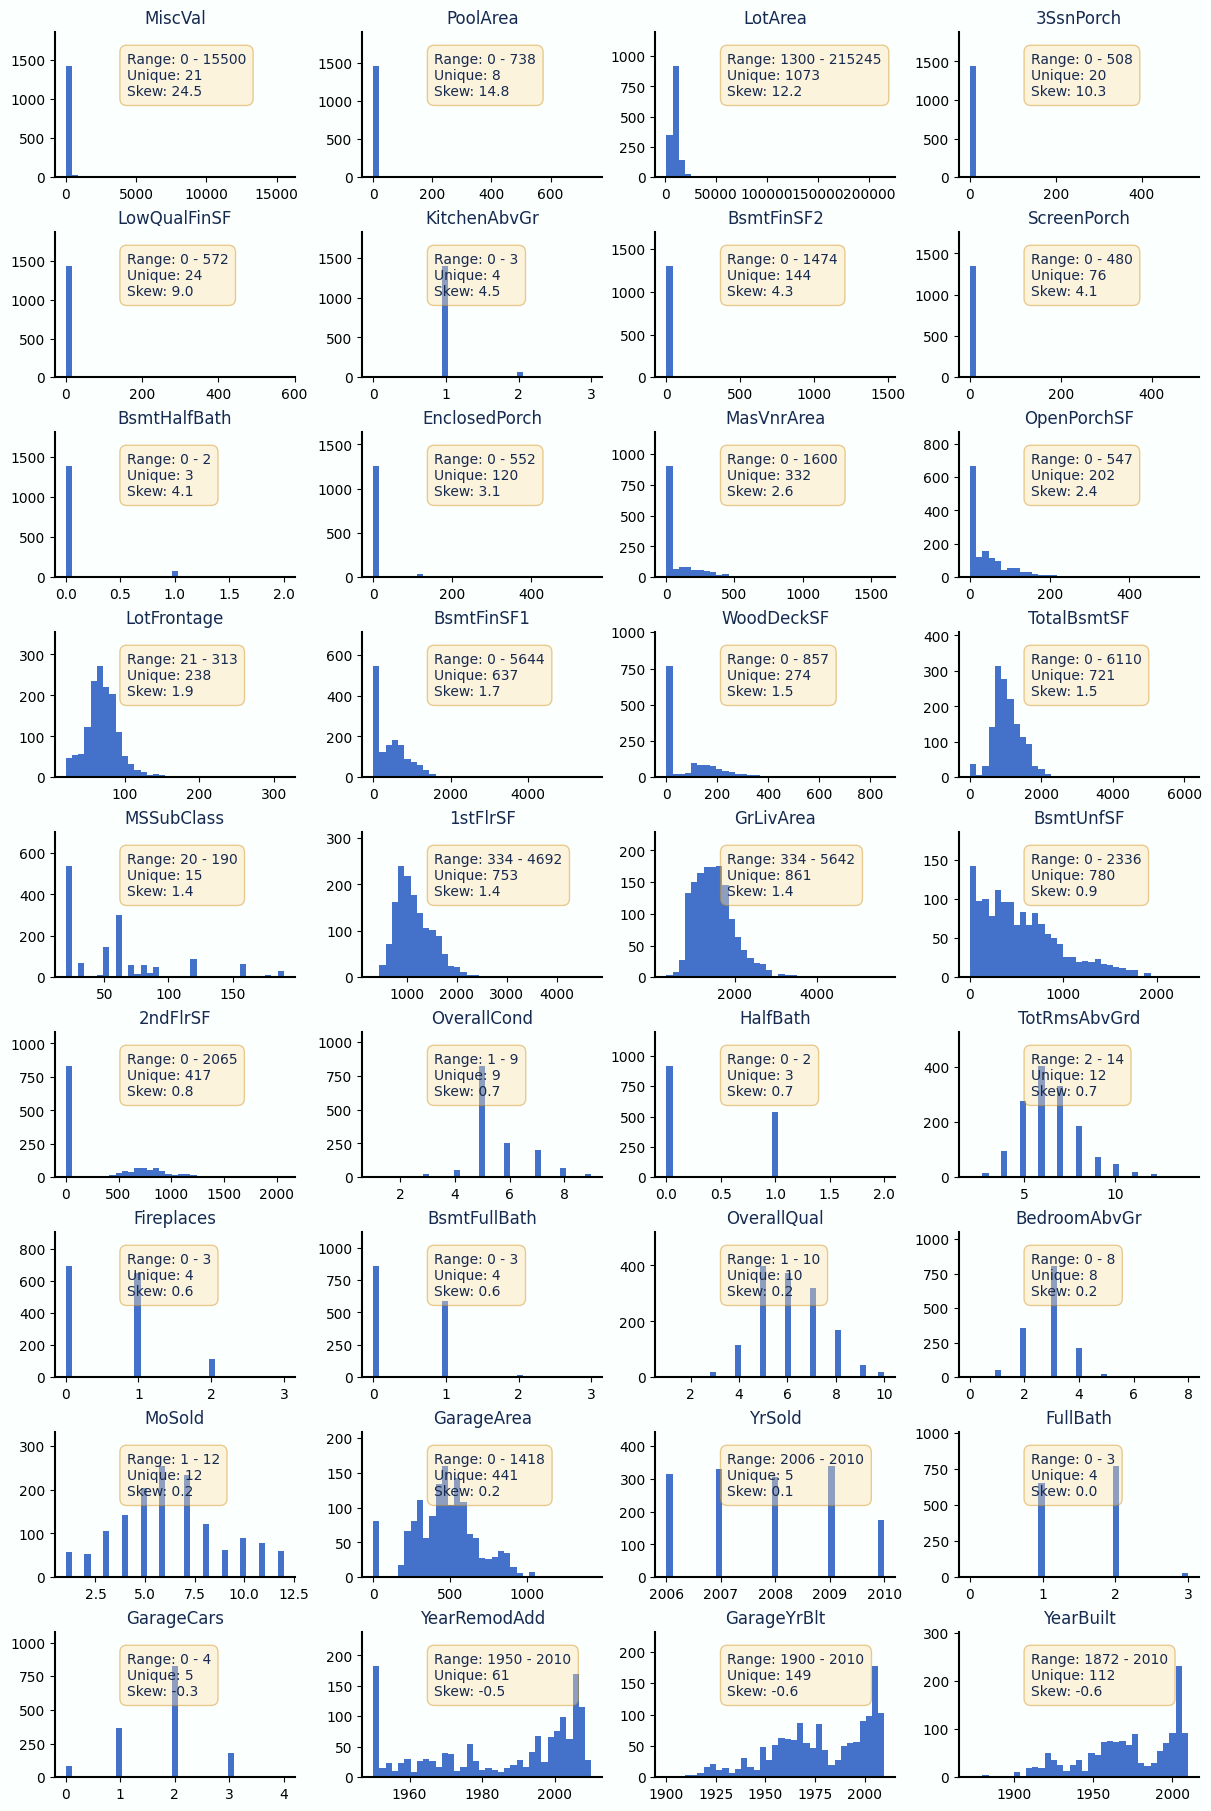

In [15]:
train[numeric_description.index].hist(bins=35, figsize=(12, 18), 
                                      layout=(9, 4), grid=False);
fig = plt.gcf()
fig.set_layout_engine('constrained')

bbox = {
    'boxstyle':'round', 
    'pad':0.5,
    'facecolor':'#FFE2AD', 
    'edgecolor':'#CC8500',
    'alpha': 0.4
}

for col_name, axi in zip(numeric_description.index, fig.get_axes()):
    col_values = train[col_name]
    axi.set_ylim(0, 1.25*axi.get_ylim()[1])
    text = f'Range: {col_values.min():.0f} - {col_values.max():.0f}\n' \
           f'Unique: {len(col_values.unique()):.0f} \n' \
           f'Skew: {skew(col_values):.1f}'
    
    axi.annotate(text, xy=(0.3, 0.7), xycoords='axes fraction', 
                 va='center', ha='left', bbox=bbox)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 15px'>
    <ul>
        <li>The features MiscVal, PoolArea, 3SsnPorch', LowQualFinSF, ScreenPorch, BsmtHalfBath, BsmtFinSF2, EnclosedPorch seems to be made by only one value. Although we could try to use this features are they are, for this project we'll try to binarize them. So for instance, for the PoolArea, all values equal to 0 will stay are they are, and all others will be transformed to 1. </li>
        <li>The features 'BsmtUnfSF', 'LotArea', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt' need to be normalized them. Because they doesen't seem to be normally distributed (which is the ideal case for almost all the machine learning models), we'll apply a box-cox transformation.</li>
        <li>For the rest of the columns, we'll just scale them with a StandardScaler.</li>
</div>

In [16]:
bin_cols = ['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'ScreenPorch', 
            'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch']
boxcox_cols = ['BsmtUnfSF', 'LotArea', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF', 
               'GrLivArea', 'GarageArea', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']

std_cols = numeric_cols.copy()
for col in bin_cols + boxcox_cols:
    std_cols.pop(std_cols.index(col))

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Categorical features
</div>

In [17]:
object_description = pd.DataFrame({
    'count_notnull': train[object_cols].notnull().sum(axis=0),
    'count_null' : train[object_cols].isnull().sum(axis=0),
    '% null': (100 * train[object_cols].isnull().sum(axis=0) / len(train)).round(1),
    'unique': [len(train[col].unique()) for col in object_cols]
}).sort_values(by='count_null', ascending=False)
object_description

,count_notnull,count_null,% null,unique
MSZoning,1460,0,0.0,5
FireplaceQu,1460,0,0.0,6
BsmtFinType1,1460,0,0.0,7
BsmtFinType2,1460,0,0.0,7
Heating,1460,0,0.0,6
HeatingQC,1460,0,0.0,5
CentralAir,1460,0,0.0,2
Electrical,1460,0,0.0,6
KitchenQual,1460,0,0.0,4
Functional,1460,0,0.0,7


(0.0, 1.0, 0.0, 1.0)

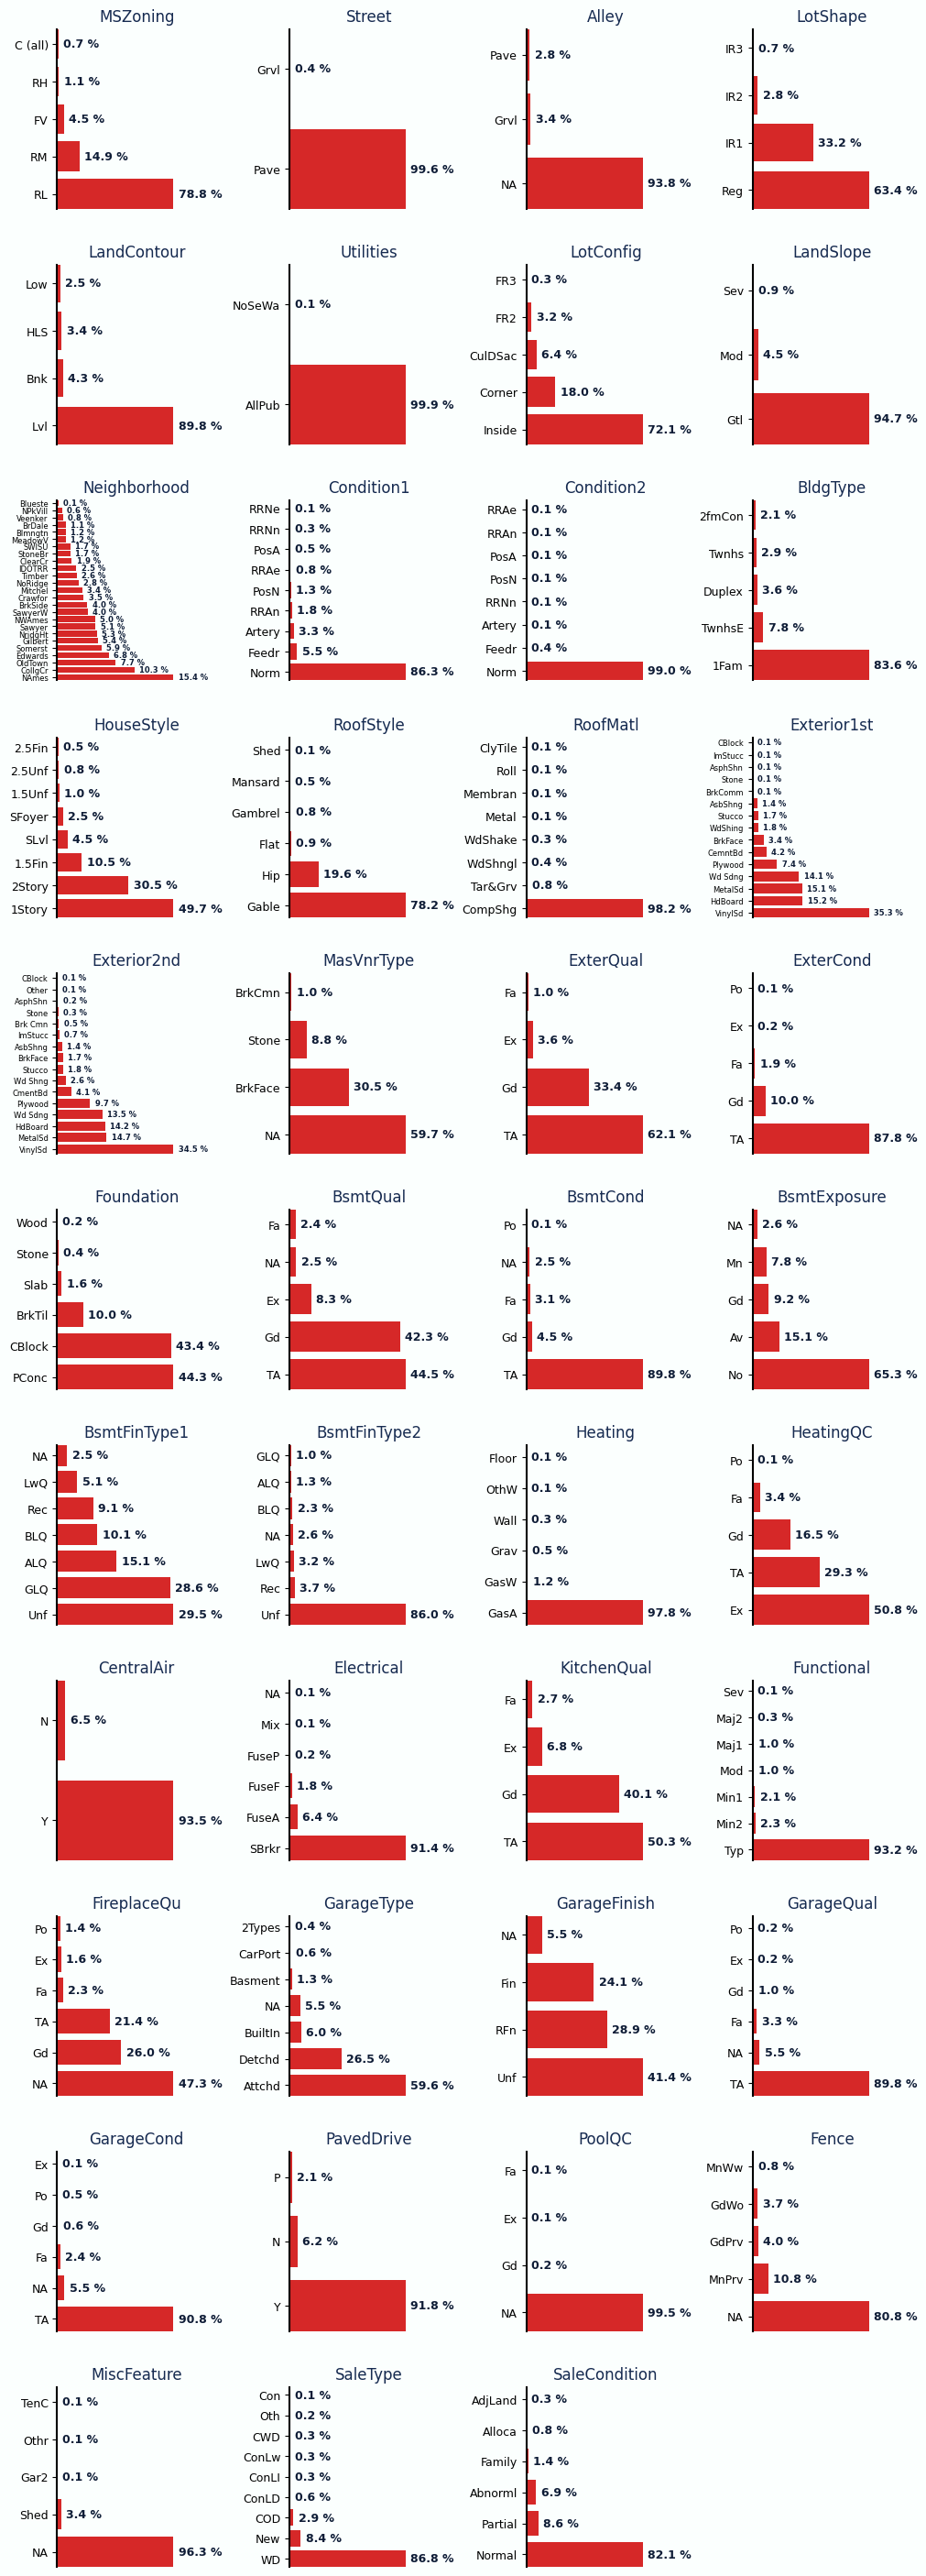

In [18]:
fig, ax = plt.subplots(11, 4, figsize=(10, 28), layout='constrained', 
                       gridspec_kw={'hspace': 0.15},)

for col_name, axi in zip(object_cols, ax.flat):
    axi.margins(y=0)
    col_values = train[col_name]
    col_value_counts = col_values.value_counts()
    bars = axi.barh(col_value_counts.index, col_value_counts, color='C1')
    for bar in bars:
        axi.annotate(f'{100*bar.get_width()/len(col_values):.1f} %', 
                     xy=(bar.get_width() + axi.get_xlim()[1]/25, bar.get_y() + bar.get_height()/2), 
                     color='C3', va='center', fontweight='bold', 
                     fontsize=9 if len(col_value_counts) < 10 else 6)

    #text = f'Unique: {len(col_values.unique()):.0f}'
    
    #axi.annotate(text, xy=(1, 1), xycoords='axes fraction', 
    #             va='top', ha='left', bbox=bbox)
    axi.set_title(col_name)
    axi.tick_params(labelsize=9 if len(col_value_counts) < 10 else 6)
    axi.spines['bottom'].set_visible(False)
    axi.set_xlim(0, axi.get_xlim()[1]*1.3)
    axi.set_xticks([])

ax.flat[-1].axis('off')

#len(object_cols)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
  Overall, there are 43 categorical features. Almost all of these features are highly unbalanced within the categories, with just one or two most frequent values. Except for the features Exterior1st, Exterior2nd and Neighborhood, all the others have justa a few categories (between 2 and 10). Altough we could try to use a OrdinalEncoder to encode the features with an ordinal level of measurement, we'll just use a OneHotEncoding strategy.
</div>

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span> Data Preparation
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
So let's apply these transformations. For simplicity, we'll fit_transform the transformers on the training data and then use them to transform the testing data (so we'll avoid the creation of a pipeline).
</div>

In [19]:
for col in numeric_cols:
    train[col] = train[col] + .0001
    test[col] = test[col] + .0001

In [20]:
general_transformer = ColumnTransformer([
    ('binarize', Binarizer(), bin_cols),
    ('standarize', StandardScaler(), std_cols), 
    ('boxcox', PowerTransformer(method='box-cox', standardize=True), boxcox_cols),
    ('encoding', OneHotEncoder(handle_unknown='ignore'), object_cols)], 
                              remainder='passthrough'
)

train = general_transformer.fit_transform(train)
test = general_transformer.transform(test)

In [21]:
train.toarray().shape, test.toarray().shape

((1460, 303), (1459, 303))

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
  Finally, both our training and testing sets are prepared for machine learning. Our final datasets have 303 different features (because of the OneHotEncoing strategy used to encode the categorical variables). Since the number of features is relatively large, we'll try to perform a feature selection technique.
</div>

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span> Regression Model for Predicting House Prices
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Most promising ML algorithm
</div>

In [22]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

models = [ElasticNet,
          LinearRegression,
          RandomForestRegressor, 
          SVR, 
          KNeighborsRegressor
]

grid_searchs = {
    LinearRegression.__name__: {}, 
    ElasticNet.__name__: {
        'max_iter': [500_000],
        'alpha': [0.001, 0.05, 1, 10, 100],
        'l1_ratio': np.arange(0, 1, 0.2)},
    RandomForestRegressor.__name__: {
        'n_estimators': [50, 100, 200, 500],
        'max_depth': [3, 5, 7, 10, 15, 20],
        'min_samples_split':[.01,.05, .1, .2, .3],
        'bootstrap': [True, False]
    },
    SVR.__name__: {
        'kernel': ['linear', 'poly', 'rbf'], 
        'C': [1, 10, 100, 1000, 10000],
        'epsilon': [.1, .3, .5]
    },
    KNeighborsRegressor.__name__: {
        'n_neighbors': [3, 5, 10, 15, 20],
        'weights': ['uniform', 'distance']
    }
}

best_params = {}
for model in models:
    param_grid = grid_searchs[model.__name__]
    search = GridSearchCV(model(), param_grid, cv=5, n_jobs=-1)
    search.fit(train, ytrain_scaled)
    best_params[model.__name__] = search.best_params_

/home/hugo/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5329484059212488, tolerance: 0.0013980113111548861
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8532716036337697, tolerance: 0.0013980113111548861
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0846561990513226, tolerance: 0.0014861207849713785
  model = cd_fast.sparse_enet_coordinate_descent(
/home/hugo/.local/lib/python3.10/site-packages/sklearn/linear

In [23]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score

model_predicts = {}
for model in models:
    est = model(**best_params[model.__name__])
    predicts = cross_val_predict(est, train, ytrain_scaled, cv=10, n_jobs=-1)
    model_predicts[model.__name__] = predicts

In [142]:
model_confidence_msle = {}

for model, predicts in model_predicts.items():
    ypred = yscaler.inverse_transform(predicts[:, None])[:, 0]
    ypred[ypred<0] = np.median(ypred)

    squared_log_errors = (np.log(1 + ypred) - np.log(1 + ytrain))**2
    conf_interval = mean_confidence_interval(squared_log_errors, 95)
    model_confidence_msle[model] = conf_interval

df_conf = pd.DataFrame(model_confidence_msle, index=['lim_inf', 'lim_sup']).T
df_conf['mean'] = df_conf.mean(axis=1)
df_conf.sort_values(by='mean')

,lim_inf,lim_sup,mean
RandomForestRegressor,0.017949,0.025311,0.021630
ElasticNet,0.017273,0.027121,0.022197
KNeighborsRegressor,0.021538,0.029910,0.025724
LinearRegression,0.021232,0.051753,0.036492
SVR,0.041727,0.057025,0.049376


Text(0.5, 0, 'Mean Squared Log Error')

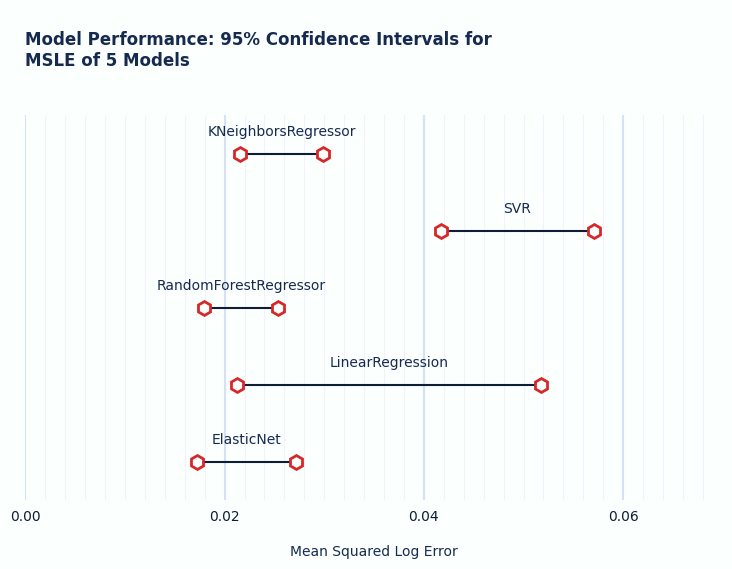

In [130]:
fig, ax = plt.subplots(figsize=(9, 5))

for i, model in enumerate(model_confidence_msle.keys()):
    ax.plot(model_confidence_msle[model], [i, i], color='C3')
    ax.plot(model_confidence_msle[model][0], [i], color='C1', 
            marker='h', markerfacecolor='#FBFFFE', markersize=10, 
            markeredgewidth=2, markeredgecolor='C1')
    ax.plot(model_confidence_msle[model][1], [i], color='C1', 
            marker='h', markerfacecolor='#FBFFFE', markersize=10, 
            markeredgewidth=2)
    ax.annotate(model, xy=(np.mean(model_confidence_msle[model]), i+0.2), 
                va='bottom', ha='center')
    ax.set_xlim(0, 0.07)

#ax.set_yticks([0, 1, 2, 3, 4], model_confidence_msle.keys())
ax.set_yticks([])
ax.set_ylim(-0.5, 4.5)
ax.tick_params(left=False, bottom=False, labelcolor='C3')
ax.tick_params(which='minor', bottom=False)
ax.spines[['bottom', 'left']].set_visible(False)
ax.grid(color='C0', alpha=0.2, lw=1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(.02))
ax.xaxis.set_minor_locator(plt.MultipleLocator(.002))
ax.grid(color='C4', alpha=0.1, which='minor')

ax.set_title('\nModel Performance: 95% Confidence Intervals for\nMSLE of 5 Models\n\n', 
              loc='left', fontsize=12, fontweight='bold')
ax.set_xlabel('Mean Squared Log Error', fontsize=10, loc='center', labelpad=15)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
    RandomForestRegressor and ElasticNet are the most promising regression models for this dataset, with a MSLE of $0.216$ and $0.222$ respectively. RandomForestRegressor is also the model with less uncertainty of the true MLSE, with a 95% conffidence interval from 0.179 to 0.253, so we're going to use this algoritm.
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Before trying to perform a deeper hyperparameter tunning on the RandomForestRegressor, let's try to perform Feature Selection using a genetic algorithm.
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Feature Selection
</div>

In [148]:
from sklearn_genetic import GAFeatureSelectionCV

est = RandomForestRegressor(**best_params[RandomForestRegressor.__name__])

fs_estimator = GAFeatureSelectionCV(
    estimator=est,
    cv=5, 
    scoring='neg_mean_squared_error',
    population_size=50, 
    generations=100, 
    max_features=75,
    n_jobs=-1, 
    keep_top_k=3, 
    elitism=True,
    verbose=True,
)

fs_estimator.fit(train.toarray(), ytrain_scaled)


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	50    	-48000 	49960      	-0.00216215	-100000    
1  	100   	-40000 	48989.8    	-0.00216215	-100000    
2  	100   	-30000 	45825.8    	-0.00216215	-100000    
3  	100   	-28000 	44899.9    	-0.00216215	-100000    
4  	100   	-28000 	44899.9    	-0.00214489	-100000    
5  	100   	-30000 	45825.8    	-0.00202759	-100000    
6  	100   	-32000 	46647.6    	-0.00202759	-100000    
7  	100   	-44000 	49638.7    	-0.00202759	-100000    
8  	100   	-40000 	48989.8    	-0.00211894	-100000    
9  	100   	-34000 	47370.9    	-0.00211894	-100000    
10 	100   	-36000 	48000      	-0.00210364	-100000    
11 	100   	-38000 	48538.6    	-0.00206089	-100000    
12 	100   	-44000 	49638.7    	-0.00206089	-100000    
13 	100   	-28000 	44899.9    	-0.00176866	-100000    
14 	100   	-34000 	47370.9    	-0.00176866	-100000    
15 	100   	-34000 	47370.9    	-0.00176866	-100000    
16 	100   	-38000 	48538.6    	-0.00176866	-100000    
17 	100   

GAFeatureSelectionCV(cv=5,
                     estimator=RandomForestRegressor(max_depth=20,
                                                     min_samples_split=0.01,
                                                     n_estimators=200),
                     generations=100, keep_top_k=3, max_features=75, n_jobs=-1,
                     scoring='neg_mean_squared_error')

In [152]:
ypred = cross_val_predict(fs_estimator.best_estimator_, 
                          train, ytrain_scaled, cv=10)

In [153]:
ypred = yscaler.inverse_transform(ypred[:, None])[:, 0]
squared_log_errores = (np.log(1 + ypred) - np.log(1 + ytrain))**2
conf_interval = mean_confidence_interval(squared_log_errores, 95)
conf_interval

[0.018005386210040174, 0.0252567716906333]

In [154]:
np.mean(conf_interval)

0.021631078950336738

In [159]:
sum(fs_estimator.support_)

72

Text(0.0, 1.0, '\nComparision between model with all (303) features and\nmodel with 72 features\n\n')

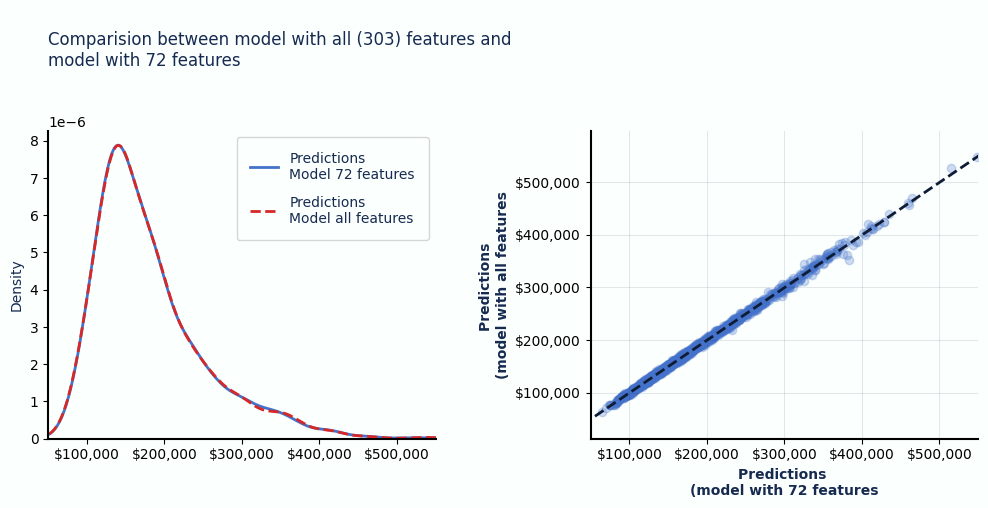

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), 
                               gridspec_kw={'wspace': 0.4})

ypred_all_features = yscaler.inverse_transform(model_predicts['RandomForestRegressor'][:, None])[:, 0]

sns.kdeplot(ypred, ls='-', lw=2, label='Predictions\nModel 72 features', ax=ax1)
sns.kdeplot(ypred_all_features, ls='--', lw=2, label='Predictions\nModel all features', ax=ax1)
ax1.legend(loc='upper right', ncols=1, labelspacing=1, borderpad=1, fancybox=True)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda vi, xi: f'${vi:,.0f}'))
ax1.set_xlim(50000, 550000)


ax2.scatter(ypred, ypred_all_features, alpha=0.25)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), color='C3', ls='--', lw=2)
ax2.set_xlim(50000, 550000)

ax2.set_xlabel('Predictions \n(model with 72 features', fontweight='bold')
ax2.set_ylabel('Predictions \n(model with all features', fontweight='bold')
ax2.grid()

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda vi, xi: f'${vi:,.0f}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda vi, xi: f'${vi:,.0f}'))

ax1.set_title('\nComparision between model with all (303) features and\nmodel with 72 features\n\n', 
              loc='left')

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
    By performing feature selection on the 303 features, we got a set of just 72 of them, reducing the dimensionality of the parameter space more than 76%. However, the predictions of both models seems to be the same. Actually, the predictions between these two models are not statistically significant, so we can be pretty conffident that the eliminated features were not relevant, and we can perform a better model selection with a simpler parameter space, less prone to overfitting the training data.
</div>

## <div style='color: #EC9898; background: #0E1C36; padding:0.75rem; border-radius: 15px; max-width: 400px'> > Hyperparameter Tunning
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Let's refine our hyperparameter tuning.
</div>

In [228]:
X = train.toarray()[:, fs_estimator.support_]

grid_search = {
        'n_estimators': [50, 100, 150, 200, 300, 500],
        'max_depth': [3, 5, 7, 10, 12, 15, 20],
        'min_samples_split':[.001, .01,.03, .05, .08, .1, .2, .3],
        'bootstrap': [True, False]
}

searcher = GridSearchCV(
    estimator=fs_estimator.best_estimator_,
    param_grid=grid_search,
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
)
searcher.fit(X, ytrain_scaled)

GridSearchCV(estimator=RandomForestRegressor(max_depth=20,
                                             min_samples_split=0.01,
                                             n_estimators=200),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 5, 7, 10, 12, 15, 20],
                         'min_samples_split': [0.001, 0.01, 0.03, 0.05, 0.08,
                                               0.1, 0.2, 0.3],
                         'n_estimators': [50, 100, 150, 200, 300, 500]},
             scoring='neg_mean_squared_log_error')

In [229]:
searcher.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_split=0.001, n_estimators=500)

In [237]:
est = RandomForestRegressor(**searcher.best_params_)
ypred = cross_val_predict(est, X, ytrain_scaled, cv=10)
ypred = yscaler.inverse_transform(ypred[:, None])[:, 0]

Text(0.0, 1.0, '\nReal vs Predicted Prices\n')

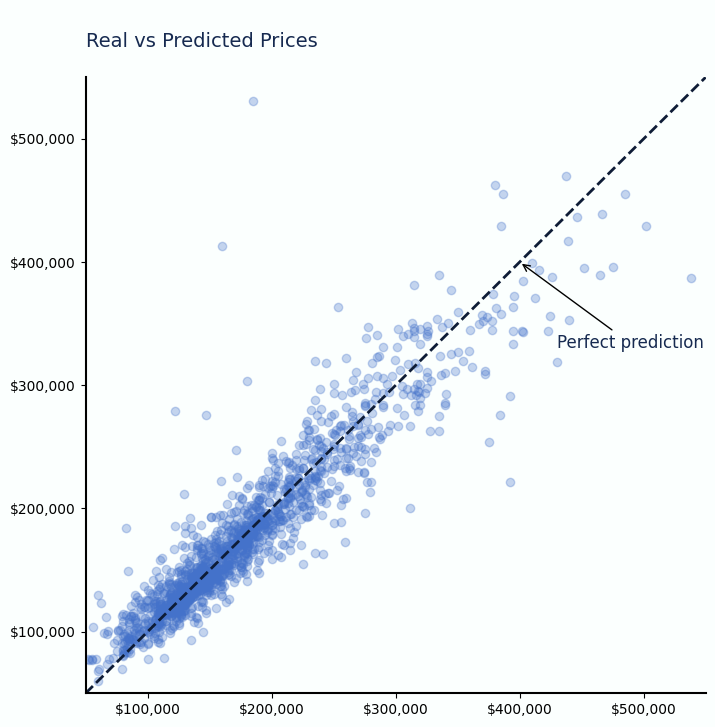

In [258]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ytrain, ypred, marker='o', alpha=0.3, ls='')
ax.set(xlim=(50000, 550000), ylim=(50000, 550000))
ax.plot(ax.get_xlim(), ax.get_ylim(), color='C3', ls='--', 
        lw=2,)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda vi, xi: f'${vi:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda vi, xi: f'${vi:,.0f}'))
ax.annotate('Perfect prediction', xy=(400000, 400000), xytext=(430000, 330000), 
            arrowprops={'arrowstyle': '->'}, xycoords='data', fontsize=12)

ax.set_title('\nReal vs Predicted Prices\n', fontsize=14, loc='left')

In [304]:
log_ytrain = np.log(ytrain)
log_ypred = np.log(ypred)

squared_errores = (log_ytrain - log_ypred)**2
conf_interval = mean_confidence_interval(squared_errores, 95)
conf_interval, np.mean(conf_interval)

([0.017456929319069017, 0.02461739394657067], 0.021037161632819844)

<div style='background: #DFE7F7; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
    We're 95% confident that our RandomForestModel has a RMSE of $0.210 \pm 0.0018$.
</div>

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span> Prediction of Train Data for Kaggle's competiotion submission
</div>

<div style='background: #E9DCF9; color: #162A50; font-size:1.15rem; padding: 1rem; border-radius: 5px'>
Finally, let's compute the predictions of the training dataset for the Kaggle's competition submission, using our final model, and the yscaler to get the inverse transform of the predictions.
</div>

In [274]:
model = RandomForestRegressor(**searcher.best_params_)
model.fit(X, ytrain_scaled)

Xtest = test.toarray()[:, fs_estimator.support_]
ytest_pred = model.predict(Xtest)
ytest_pred = yscaler.inverse_transform(ytest_pred[:, None])[:, 0]

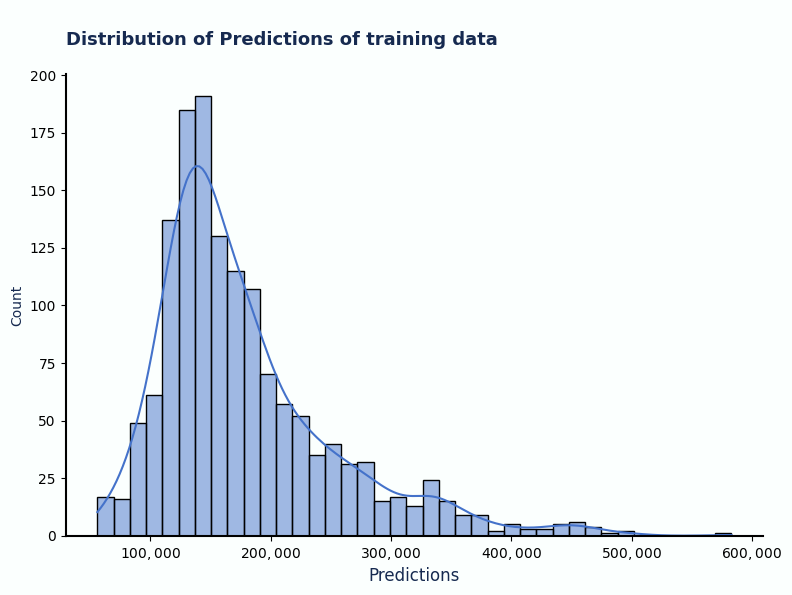

In [290]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(ytest_pred, kde=True, color='C0', line_kws={'color': 'C2'})
ax.set_title('\nDistribution of Predictions of training data\n', fontweight='bold', loc='left', 
             fontsize=13)
ax.set_xlabel('Predictions', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, xi: f'${val:,.0f}$'))

In [295]:
submission_file = pd.DataFrame({
    'Id': pd.read_csv('test.csv')['Id'],
    'SalePrice': ytest_pred
})
submission_file

,Id,SalePrice
0,1461,123038.762387
1,1462,152620.583333
2,1463,167432.276420
3,1464,185811.717997
4,1465,197216.490000
...,...,...
1454,2915,87330.702000
1455,2916,85257.864000
1456,2917,156775.972000
1457,2918,112720.100667


In [297]:
submission_file.to_csv('Submission.csv', index=False)

# <div style='color: #FFF8EB; background: #0E1C36; padding: 2rem; border-radius: 15px; font-weight:bold'><span style='color: #EC9898'> >>> </span> Conclusions
</div>